## 1. Data preparation
<font color=grey>*First, I load all the modules that will be used in this notebook*</font>

In [1]:
!pip install jsonlines

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


tet

In [2]:
import os
import sys
import csv, jsonlines
import json
import numpy as np
import copy
import random
import pandas as pd
import boto3
import matplotlib.pyplot as plt
from pandas import DataFrame
from io import StringIO
from io import BytesIO
from sagemaker import get_execution_role
from sagemaker.session import s3_input
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sagemaker.predictor import json_serializer, json_deserializer
%matplotlib inline

<font color=grey>*Then, I load the data. Once done, I also give some basic informations on the content of the dataframe: the type of the various variables, the number of null values and their percentage with respect to the total number of entries*</font>

In [3]:
role = get_execution_role()
bucket = 'sagemaker-studio-6jwjvvi6359'
subfolder = ''
conn = boto3.resource('s3')
conn.Bucket(bucket)


# show file name in s3 bucket 
## allFiles = conn.Bucket(bucket).objects.all()
## for file in allFiles:
##     print(file.key)

s3.Bucket(name='sagemaker-studio-6jwjvvi6359')

In [4]:
df = pd.read_csv('s3://sagemaker-studio-6jwjvvi6359/data_samples/05_28_2021_062354/unsummarized/datasample_1.csv', error_bad_lines=False, engine='python')
df.head()

,Unnamed: 0,maybe_price,likely_order_price,qty,customer_id,customer_name,date,product,date_filledna
0,13566,363.6,909.0,1.0,115043382,REITER BROS,2009-05-21,TABLE-UNIVERSAL BASE ...,False
1,14082,905.4,3018.0,7.0,999007692,POWER MAGNETICS INC,2009-05-13,B-Style Flipper Door Unit ...,False
2,14083,384.3,1281.0,11.0,999007692,POWER MAGNETICS INC,2009-05-13,Base Power Harness ...,False
3,14084,1785.6,5952.0,50.0,999007692,POWER MAGNETICS INC,2009-05-13,Full-Height Tile ...,False
4,14085,51.0,170.0,2.0,999007692,POWER MAGNETICS INC,2009-05-13,Power Jumper ...,False


In [5]:
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(tab_info)

,Unnamed: 0,maybe_price,likely_order_price,qty,customer_id,customer_name,date,product,date_filledna
column type,int64,float64,float64,float64,int64,object,object,object,object
null values (nb),0,0,0,0,0,0,0,0,11553
null values (%),0,0,0,0,0,0,0,0,21.753


<font color=grey>Get unique customer and product</font>

In [6]:
unique_product = DataFrame(df['product'].value_counts()).reset_index()
unique_product

,index,product
0,Finished End ...,1044
1,Frame ...,1020
2,Frame Top Cap ...,856
3,Frame-to-Frame Connection Hardware ...,849
4,"CHAIR, AERON ""B"" ...",794
...,...,...
3265,Vivo Square Edge Transaction Surface Fastener ...,1
3266,"Eames® Occasional Table, Round ...",1
3267,Sit-to-Stand Keyboard Support ...,1
3268,Straight Back Panel Conversion Kit ...,1


<font color=grey>Then I remove the customers have too few products purchase and product that too few customers bought. product: more than 30 bought(remaining 73.7%). customer: more than 20 bought(remaining 77%)</font>

In [7]:
unique_product = unique_product[unique_product['product'] >= 30]
## unique_product = unique_product[unique_product['product'] < 25000]
unique_product['product_index'] = unique_product.index
unique_product.rename(columns={'index':'product','product':'count'}, inplace=True)
unique_product

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,product,count,product_index
0,Finished End ...,1044,0
1,Frame ...,1020,1
2,Frame Top Cap ...,856,2
3,Frame-to-Frame Connection Hardware ...,849,3
4,"CHAIR, AERON ""B"" ...",794,4
...,...,...,...
288,Screen Brackets ...,30,288
289,Wood Freestanding Lateral File ...,30,289
290,Architectural Foot ...,30,290
291,"PANEL-TACKABLE, THIN ...",30,291


In [8]:
unique_customer = DataFrame(df['customer_id'].value_counts()).reset_index()
unique_customer

,index,customer_id
0,609144555,170
1,613866735,170
2,826930104,170
3,129974270,169
4,41460502,168
...,...,...
995,62511126,6
996,999008844,6
997,622255594,6
998,54228306,6


In [9]:
unique_customer = unique_customer[unique_customer['customer_id'] >= 20]
unique_customer['customer_index'] = unique_customer.index
unique_customer.rename(columns={'index':'customer_id','customer_id':'count'}, inplace=True)
unique_customer

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,customer_id,count,customer_index
0,609144555,170,0
1,613866735,170,1
2,826930104,170,2
3,129974270,169,3
4,41460502,168,4
...,...,...,...
764,868982612,20,764
765,248361248,20,765
766,999007294,20,766
767,999008337,20,767


<font color=grey>*Histogram of customer and product*</font>

Text(0, 0.5, 'Product count')

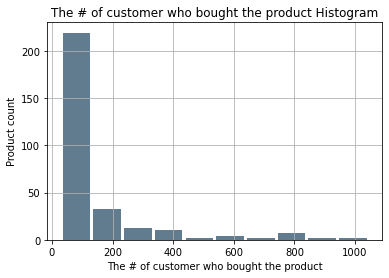

In [10]:
unique_product['count'].plot.hist(grid=True, bins=10, rwidth=0.9,
                    color='#607c8e')
plt.title('The # of customer who bought the product Histogram')
plt.xlabel('The # of customer who bought the product')
plt.ylabel('Product count')

Text(0, 0.5, 'Customer count')

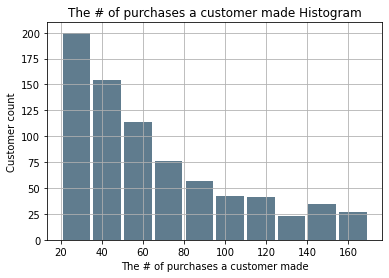

In [11]:
unique_customer['count'].plot.hist(grid=True, bins=10, rwidth=0.9,
                    color='#607c8e')
plt.title('The # of purchases a customer made Histogram')
plt.xlabel('The # of purchases a customer made')
plt.ylabel('Customer count')

<font color=grey>Build the data for training: adding customer*product matrix(including all combination even they didnt make the purchase)</font>

In [12]:
hm = pd.merge(df, unique_product, left_on='product', right_on='product')
hm = pd.merge(hm, unique_customer, left_on='customer_id', right_on='customer_id')
hm = hm[['customer_index', 'product_index', 'qty']]
hm['qty'] = hm['qty'].astype('float64').astype('int64')
hm

,customer_index,product_index,qty
0,696,217,1
1,696,29,14
2,696,69,6
3,696,86,4
4,696,86,2
...,...,...,...
37326,563,280,17
37327,563,264,19
37328,563,264,3
37329,563,278,48


In [13]:
hm_unique_product = DataFrame(hm['product_index'].value_counts()).reset_index()
hm_unique_product.rename(columns={'index':'product_index','product_index':'count'}, inplace=True)
total = DataFrame()
for i in range(0,len(unique_product)):
    tem = hm_unique_product[['product_index']]
    tem['qty'] = 0
    tem['customer_index'] = i
    tem_hm = hm[hm['customer_index'] == i]
    tem_product = DataFrame(tem_hm['product_index'].value_counts()).reset_index()
    tem_product.rename(columns={'index':'product_index','product_index':'rm'}, inplace=True)
    tem_final = pd.merge(tem, tem_product, how='left', on=['product_index','product_index'], indicator=True)
    tem_final.drop(columns=['rm','_merge'], inplace = True)
    total = pd.concat([total, tem_final, tem_hm])
total

,product_index,qty,customer_index
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,5,0,0
...,...,...,...
10933,68,2,292
10934,31,6,292
10935,31,24,292
10936,76,8,292


In [14]:
total['product'] = total['product_index']
total['label'] = 1
for i in range(0,len(total)):
    if total.iloc[i, 1] == 0:
        total.iloc[i, 4] = 0

In [15]:
total = total.reset_index().drop(columns=['qty','index','product_index'])
total.rename(columns={'product':'product_index'}, inplace=True)
total

,customer_index,product_index,label
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,5,0
...,...,...,...
109412,292,68,1
109413,292,31,1
109414,292,31,1
109415,292,76,1


<font color=grey>*Spilit the data into train and validation set*</font>

In [19]:
train_h, validation_h = train_test_split(total, test_size=0.2, random_state=23)

In [20]:
def load_csv_data(filename, delimiter, verbose=True):
    """
    input: a file readable as csv and separated by a delimiter
    and has format users - movies - ratings - etc
    output: a list, where each row of the list is of the form
    {'in0':userID, 'in1':movieID, 'label':rating}
    """
    to_data_list = list()
    customer_id = list()
    product = list()
    qty = list()
    unique_customer = set()
    unique_product = set()
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile, delimiter=delimiter)
        for count, row in enumerate(reader):
            # if count!=0:
            to_data_list.append(
                {"in0": [int(row[0])], "in1": [int(row[1])], "label": int(row[2])}
            )
            customer_id.append(row[0])
            product.append(row[1])
            qty.append(int(row[2]))
            unique_customer.add(row[0])
            unique_product.add(row[1])
    if verbose:
        print("In file {}, there are {} qty".format(filename, len(qty)))
        print(
            "The qty have mean: {}, median: {}, and variance: {}".format(
                round(np.mean(qty), 2), round(np.median(qty), 2), round(np.var(qty), 2)
            )
        )
        print(
            "There are {} unique customer and {} unique product".format(
                len(unique_customer), len(unique_product)
            )
        )
    return to_data_list

def write_data_list_to_jsonl(data_list, to_fname):
    """
    Input: a data list, where each row of the list is a Python dictionary taking form
    {'in0':userID, 'in1':movieID, 'label':rating}
    Output: save the list as a jsonline file
    """
    with jsonlines.open(to_fname, mode="w") as writer:
        for row in data_list:
            # print(row)
            writer.write({"in0": row["in0"], "in1": row["in1"], "label": row["label"]})
    print("Created {} jsonline file".format(to_fname))

def data_list_to_inference_format(data_list, binarize=True, label_thres=3):
    """
    Input: a data list
    Output: test data and label, acceptable by SageMaker for inference
    """
    data_ = [({"in0": row["in0"], "in1": row["in1"]}, row["label"]) for row in data_list]
    data, label = zip(*data_)
    infer_data = {"instances": data}
    if binarize:
        label = get_binarized_label(list(label), label_thres)
    return infer_data, label   

<font color=grey>*Convert CSV file into JSONL for Object2Vec*</font>

In [21]:
train_h.to_csv('train_h.csv', index=False, header=False)
validation_h.to_csv('validation_h.csv', index=False, header=False)
train_h = load_csv_data('train_h.csv', ",")
validation_h = load_csv_data('validation_h.csv', ",")
random.shuffle(train_h)
random.shuffle(validation_h)
write_data_list_to_jsonl(copy.deepcopy(train_h), "train_h.jsonl")
write_data_list_to_jsonl(copy.deepcopy(validation_h), "validation_h.jsonl")

In file train_h.csv, there are 87533 qty
The qty have mean: 0.22, median: 0.0, and variance: 0.17
There are 293 unique customer and 293 unique product
In file validation_h.csv, there are 21884 qty
The qty have mean: 0.22, median: 0.0, and variance: 0.17
There are 293 unique customer and 293 unique product
Created train_h.jsonl jsonline file
Created validation_h.jsonl jsonline file


<font color=grey>*Set up hyperparameters for the model*</font>

hyperparameters = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3,
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 1000,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 500,
    "enc_dim": 1024,
    "epochs": 50,
    "learning_rate": 0.001,
    "mini_batch_size": 64,
    "mlp_activation": "tanh",
    "mlp_dim": 256,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "softmax",
}

<font color=grey>*Set up input & output paths for the model*</font>

In [51]:
input_prefix = "object2vec/hm/input"
output_prefix = "object2vec/hm/output"

s3_client = boto3.client("s3")
input_paths = {}
output_path = os.path.join("s3://", bucket, output_prefix)


In [52]:
for data_name in ["train", "validation"]:
    pre_key = os.path.join(input_prefix, "rating", f"{data_name}")
    fname = "{}_h.jsonl".format(data_name)
    data_path = os.path.join("s3://", bucket, pre_key, fname)
    s3_client.upload_file(fname, bucket, os.path.join(pre_key, fname))
    input_paths[data_name] = s3_input(
        data_path, distribution="ShardedByS3Key", content_type="application/jsonlines"
    )
    print("Uploaded {} data to {} and defined input path".format(data_name, data_path))

print("Trained model will be saved at", output_path)

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Uploaded train data to s3://sagemaker-studio-6jwjvvi6359/object2vec/hm/input/rating/train/train_h.jsonl and defined input path
Uploaded validation data to s3://sagemaker-studio-6jwjvvi6359/object2vec/hm/input/rating/validation/validation_h.jsonl and defined input path
Trained model will be saved at s3://sagemaker-studio-6jwjvvi6359/object2vec/hm/output


<font color=grey>*Get docker image of ObjectToVec algorithm*</font>

In [53]:
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()
role = get_execution_role()
print(role)

from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, "object2vec")


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


arn:aws:iam::361274059216:role/sagemakerwiths3


<font color=grey>*Get estimator and train the model*</font>

In [ ]:
regressor = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.p2.xlarge",
    output_path=output_path,
    sagemaker_session=sess,
)

regressor.set_hyperparameters(**hyperparameters)

regressor.fit(input_paths)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2021-07-01 07:20:06 Starting - Starting the training job...
2021-07-01 07:20:29 Starting - Launching requested ML instancesProfilerReport-1625124006: InProgress
......
2021-07-01 07:21:30 Starting - Preparing the instances for training............
2021-07-01 07:23:32 Downloading - Downloading input data
2021-07-01 07:23:32 Training - Downloading the training image....Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/01/2021 07:24:15 INFO 140235243456320] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'enc_dim': 4096, 'mlp_dim': 512, 'mlp_activation': 'linear', 'mlp_layers': 2, 'output_layer': 'softmax', 'optimizer': 'adam', 'learning_rate': 0.0004, 'mini_batch_size': 32, 'epochs': 30, 'bucket_width': 0, 'early_stopping_tolerance': 0.01, 'early_stopping_patience': 3, 'dropout': 0, 'weight_decay': 0, 'negative_sampling_rate': 0, 'comparator_list': 'hadamard, concat, abs_diff', '

<font color=grey>*Deploy the model*</font>

In [ ]:
predictor = regressor.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge",serializer=json_serializer,
deserializer=json_deserializer)

---------------!

In [ ]:
def get_mse_loss(res, labels):
    if type(res) is dict:
        res = res["predictions"]
    assert len(res) == len(labels), "result and label length mismatch!"
    loss = 0
    for row, label in zip(res, labels):
        if type(row) is dict:
            loss += (row["scores"][0] - label) ** 2
        else:
            loss += (row - label) ** 2
    return round(loss / float(len(labels)), 2)

valid_r_data, valid_r_label = data_list_to_inference_format(
    copy.deepcopy(validation_h), binarize=False
)

<font color=grey>*Send data to the endpoint to get predictions*</font>

In [ ]:
# Send data to the endpoint to get predictions
prediction = predictor.predict(valid_r_data)

print("The mean squared error on validation set is %.3f" % get_mse_loss(prediction, valid_r_label))


The json_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


The mean squared error on validation set is 0.700


In [69]:
result = DataFrame(index=range(len(prediction['predictions'])),columns=['customer_index','product_index','label','score'])
for i in range(0, len(prediction['predictions'])):
    result.iloc[i,0] = valid_r_data['instances'][i]['in0'][0]
    result.iloc[i,1] = valid_r_data['instances'][i]['in1'][0]
    result.iloc[i,2] = valid_r_label[i]
    result.iloc[i,3] = 1 - prediction['predictions'][i]['scores'][0]
    

In [87]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(result)

,customer_index,product_index,label,score
0,245,279,0,0.0236791
1,223,159,0,0.0555819
2,282,63,1,0.517463
3,144,7,0,0.708012
4,155,87,0,0.160429
...,...,...,...,...
21879,209,4,1,0.169133
21880,76,90,1,0.298125
21881,60,232,0,0.0400223
21882,166,89,0,0.330755


In [70]:
fpr, tpr, thresholds = metrics.roc_curve(valid_r_label, result['score'], pos_label=1)


In [71]:
roc_auc = metrics.auc(fpr, tpr)


In [72]:
roc_auc


0.8864567060566915

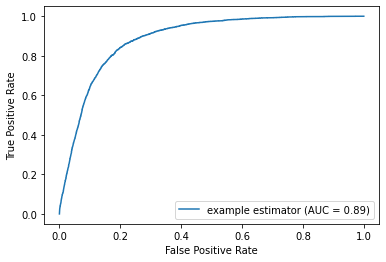

In [73]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()  
plt.show()      

In [64]:
## clean up
sess.delete_endpoint(predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-2:361274059216:endpoint/object2vec-2021-07-01-07-25-49-927".

hyperparameters = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3,
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 1000,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 500,
    "enc_dim": 1024,
    "epochs": 20,
    "learning_rate": 0.001,
    "mini_batch_size": 64,
    "mlp_activation": "tanh",
    "mlp_dim": 256,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "mean_squared_error",
}
product > 20
customer >10
bought vs non-bought 1:4.17
AUC = 0.89

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from model with message "Your invocation timed out while waiting for a response from container model. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-2.console.aws.amazon.com/cloudwatch/home?region=us-east-2#logEventViewer:group=/aws/sagemaker/Endpoints/object2vec-2021-06-21-17-00-38-310 in account 361274059216 for more information.

hyperparameters = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3,
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 1000,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 500,
    "enc_dim": 1024,
    "epochs": 20,
    "learning_rate": 0.001,
    "mini_batch_size": 64,
    "mlp_activation": "tanh",
    "mlp_dim": 256,
    "mlp_layers": 2,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "mean_squared_error",
}
product > 30
customer >20
bought vs non-bought 1:1.93
AUC = 0.8687031016708031

hyperparameters = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3,
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 1000,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 500,
    "enc_dim": 1024,
    "epochs": 20,
    "learning_rate": 0.001,
    "mini_batch_size": 64,
    "mlp_activation": "tanh",
    "mlp_dim": 256,
    "mlp_layers": 3,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "mean_squared_error",
}
product > 30
customer >20
bought vs non-bought 1:1.93
AUC = 0.8651994285604099

hyperparameters = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3,
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 1000,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 500,
    "enc_dim": 1024,
    "epochs": 20,
    "learning_rate": 0.001,
    "mini_batch_size": 64,
    "mlp_activation": "tanh",
    "mlp_dim": 256,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "mean_squared_error",
}
product > 30
customer >20
bought vs non-bought 1:1.93
AUC = 0.875526927748067


hyperparameters = { "_kvstore": "device", "_num_gpus": "auto", "_num_kv_servers": "auto", "bucket_width": 0, "early_stopping_patience": 3, "early_stopping_tolerance": 0.01, "enc0_cnn_filter_width": 3, "enc0_layers": "auto", "enc0_max_seq_len": 1, "enc0_network": "pooled_embedding", "enc0_token_embedding_dim": 300, "enc0_vocab_size": 1000, "enc1_layers": "auto", "enc1_max_seq_len": 1, "enc1_network": "pooled_embedding", "enc1_token_embedding_dim": 300, "enc1_vocab_size": 500, "enc_dim": 1024, "epochs": 50, "learning_rate": 0.001, "mini_batch_size": 64, "mlp_activation": "tanh", "mlp_dim": 256, "mlp_layers": 1, "num_classes": 2, "optimizer": "adam", "output_layer": "mean_squared_error", } 
product > 30 
customer >20 
bought vs non-bought 1:1.93 
AUC = 0.8751089230168129

hyperparameters = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3,
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 1000,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 500,
    "enc_dim": 1024,
    "epochs": 50,
    "learning_rate": 0.001,
    "mini_batch_size": 64,
    "mlp_activation": "tanh",
    "mlp_dim": 256,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "softmax",
}
product > 30 
customer >20 
bought vs non-bought 1:1.93 
AUC = 0.8864567060566915